## Final Project

### Prepare Environment

Install libraries and load modules

In [ ]:
!pip install python-chess==1.2.0

In [ ]:
# use ray which is 10x faster than the multiprocessing libary in python
!pip install -U ray

     |████████████████████████████████| 57.6 MB 117.5 MB/s 
     |████████████████████████████████| 119 kB 76.1 MB/s 


In [ ]:
!pip install numpy --upgrade

In [ ]:
!wget https://stockfishchess.org/files/stockfish_14.1_linux_x64.zip
!unzip -o stockfish_14.1_linux_x64.zip
!chmod +x stockfish_14.1_linux_x64/stockfish_14.1_linux_x64

--2021-12-09 14:26:34--  https://stockfishchess.org/files/stockfish_14.1_linux_x64.zip
Resolving stockfishchess.org (stockfishchess.org)... 104.25.158.9, 172.67.80.249, 104.25.159.9, ...
Connecting to stockfishchess.org (stockfishchess.org)|104.25.158.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28788691 (27M) [application/zip]
Saving to: ‘stockfish_14.1_linux_x64.zip’

stockfish_14.1_linu 100%[===================>]  27.45M  --.-KB/s    in 0.1s    

2021-12-09 14:26:34 (199 MB/s) - ‘stockfish_14.1_linux_x64.zip’ saved [28788691/28788691]

Archive:  stockfish_14.1_linux_x64.zip
  inflating: stockfish_14.1_linux_x64/AUTHORS  
  inflating: stockfish_14.1_linux_x64/Copying.txt  
  inflating: stockfish_14.1_linux_x64/info.txt  
  inflating: stockfish_14.1_linux_x64/stockfish_14.1_linux_x64  
   creating: stockfish_14.1_linux_x64/stockfish_14.1_src/
   creating: stockfish_14.1_linux_x64/stockfish_14.1_src/.github/
   creating: stockfish_14.1_linux_x64/stockfish

### Imports

In [ ]:
import chess
import chess.pgn as pgn
import chess.engine
import gc
import matplotlib.pyplot as plt

import psutil
import ray
from ray.util.multiprocessing import Pool

import numpy as np
import math
import random
from datetime import date
import time
from IPython.display import display
import pandas as pd

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend

#import keras as K
#from keras import optimizers
#from keras import layers
#from keras import models
#from keras import backend

In [ ]:
# increase limits for multiprocessing
import sys
sys.setrecursionlimit(10000)

if ray.is_initialized():
  ray.shutdown()
ray.init()
pool = Pool()

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
for gpu in tf.config.list_physical_devices('GPU'):
    print('\t{}'.format(gpu))

Num GPUs Available:  1
	PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
print('TensorFlow Version: {}'.format(tf.__version__))
print('Keras Version: {}'.format(tf.keras.__version__))
print('Numpy Version: {}'.format(np.version.version))

TensorFlow Version: 2.7.0
Keras Version: 2.7.0
Numpy Version: 1.21.4


In [ ]:
import os
os.getcwd()
save_path = os.getcwd() + '/Models'
print('Save path set to: {}'.format(save_path))

Save path set to: /content/Models


### Class: Node

The class node is used to build trees for use in a monte carlo tree search

In [ ]:
class node():
  def __init__(self):
    self.state = chess.Board()
    self.action = ''
    self.children = set()
    self.parent = None
    self.N = 0
    self.n = 0
    self.v = 0

choices = []

def reset_choices():
  global choices
  choices = []

### Class: ActionSpace

The ActionSpace class is used to interprete current state of a game

In [ ]:
class ActionSpace():
  def __init__(self, board):
    self.board = board

  def sample(self) -> str:
    """
    Returns a random legal move as a string in algebraic notation
    :return: move as a string
    """
    return random.choice(self.available_actions())

    def available_actions(self) -> list[str]:
      """
      Returns a list of legal moves as a list of strings where the moves
      are in algebraic notation
      :return: list of moves
      """
      legal_moves = list(self.board.legal_moves)
      legal_moves_str = [str(move) for move in legal_moves]
      return legal_moves_str

### Class: ChessEnv

Configures a chess environment for use in a game

In [ ]:
class ChessEnv():
  """
  Chess Environment. Player is always white. Opponent is black
  """

  def __init__(self, opponent):
    self.opponent = opponent
    self.board = chess.Board()
    self.game = chess.pgn.Game()
    self.game.headers['White'] = 'Player'
    if self.opponent != None:
      self.game.headers['Black'] = self.opponent.name
    self.game.headers['Date'] = str(date.today())
    self.node = self.game
    if self.opponent != None:
      self.action_space = ActionSpace(self.board)
    else:
      self.init_action_space()
      self.layer_board = np.zeros(shape=(8,8,8))
    self.init_layer_board()

  def init_action_space(self):
    """
    Initialize the actions space
    """
    self.action_space = np.zeros(shape=(64,64))
  
  def init_layer_board(self):
    """
    Initialize the numerical representation of the envrionment
    """
    mapper = {'p': 0, 'r': 1, 'n': 2, 'b': 3, 'q': 4, 'k': 5, 'P': 0, 'R': 1, 'N': 2, 'B': 3, 'Q': 4, 'K': 5}
    self.layer_board = np.zeros(shape=(8,8,8))
    for i in range(64):
      row = i // 8
      col = i % 8
      piece = self.board.piece_at(i)
      if piece == None:
        continue
      elif piece.symbol().isupper():
        sign = 1
      else:
        sign = -1
      layer = mapper[piece.symbol()]
      self.layer_board[layer, row, col] = sign
    if self.board.turn:
      self.layer_board[6, :, :] = 1 / self.board.fullmove_number
    if self.board.can_claim_draw():
      self.layer_board[7, :, :] = 1

  def _observation(self) -> str:
    """
    Returns the state of the game in Forsyth-Edwards Notation (FEN)
    :return: observation
    """
    return self.board.fen()

  def _is_done(self) -> bool:
    """
    :return: Return True if the game is over, else False
    """
    return self.board.is_game_over()

  def _reward(self) -> int:
    """
    Returns a reward from white's perspective
    Game not over = 0
    Win = +1
    Loss = -1
    Draw = 0
    :return: reward
    """
    if not self._is_done():
      reward = 0
    else:
      result = self.board.result()
      if result == '1-0':
        reward = 1
      elif result == '0-1':
        reward = -1
      elif result == '1/2-1/2':
        reward = 0
      else:
        raise Exception('Unknown end game state')
    return reward

  def reset(self) -> str:
    """
    Resets the game and returns an observation
    :return: observaction
    """
    self.board = chess.Board()
    self.game = chess.pgn.Game()
    self.game.headers['White'] = 'Player'
    if self.opponent != None:
      self.game.headers['Black'] = self.opponent.name
      self.init_action_space()
    self.game.headers['Date'] = str(date.today())
    self.node = self.game
    self.init_layer_board()
    return self._observation

  def render_image(self, **kwargs):
    return chess.svg.board(self.board, **kwargs)

  def render_txt(self):
    print('\n')
    print(self.board)
    print('\n')

  def render_image_jupyter(self):
    display(self.board)

  def step(self, action: str):
    """
    :param action: action in san
    """
    self.board.push_san(action)

  def step_numerical(self, action):
    """
    Run a step
    Args:
      action: tuple of 2 integers
        Move from, Move to
    Returns:
      episode end: Boolean
        Whether the episode has ended
      reward: int
        Difference in material value after the move
    """
    piece_balance_before = self.get_material_value()
    self.board.push(action)
    self.init_layer_board()
    piece_balance_after = self.get_material_value()
    if self.board.result() == '*':
      opponent_move = self.get_random_action()
      self.board.push(opponent_move)
      self.init_layer_board()
      capture_reward = piece_balance_after - piece_balance_before
      if self.board.result() == '*':
        reward = 0 + capture_reward
        episode_end = False
      else:
        reward = 0 + capture_reward
        episode_end = True
    else:
      capture_reward = piece_balance_after - piece_balance_before
      reward = 0 + capture_reward
      episode_end = True
    if self.board.is_game_over():
      reward = 0
      episode_end = True
    return episode_end, reward

  def get_random_action(self):
    """
    Sample a random action
    Returns: move
      A legal chess move
    """
    legal_moves = [x for x in self.board.generate_legal_moves()]
    legal_moves = np.random.choice(legal_moves)
    return legal_moves

  def get_material_value(self):
    """
    Sums up the material balance using Reinfield values
    Returns: The material balance on the board
    """
    pawns = 1 * np.sum(self.layer_board[0, :, :])
    rooks = 5 * np.sum(self.layer_board[1, :, :])
    minor = 3 * np.sum(self.layer_board[2:4, :, :])
    queen = 9 * np.sum(self.layer_board[4, :, :])
    return pawns + rooks + minor + queen

  def project_legal_moves(self):
    """
    Create a mask of legal actions
    Returns: np.ndarray with shape (64, 64)
    """
    self.action_space = np.zeros(shape=(64, 64))
    moves = [[x.from_square, x.to_square] for x in self.board.generate_legal_moves()]
    for move in moves:
      self.action_space[move[0], move[1]] = 1
    return self.action_space

### Class: MCTSAgent()

Create an agent that uses monte carlo tree search to determine a move

In [ ]:
class MCTSAgent():
    def __init__(self, name: str, is_white: bool, multithreading=True):
        self.name = name
        self.is_white = is_white
        self.multithreading = multithreading
        print('Created Agent ''{}'' as {}; multithreading: {}'.\
              format(name, 'White' if is_white else 'Black', multithreading))

    def expand(self, current_node):
        """
        Expanding is used to increase the options further in the game by expanding
        the selected node and creating many children nodes
        :param current_node: node to expand, is_white: white or black player
        :return: the current node with the expanded children
        """
        if len(current_node.children) == 0:
            return current_node
        expanded_child = self.mcts_identify_best_ucb(current_node, self.is_white, True)
        return self.expand(expanded_child)

    def rollout(self, current_node):
        """
        Run a simulated rollout from M until a terminal state is found. The terminal state 
        contains a result (value) that will be returned to upwards in the is 
        backpropagation phase
        params: current_node: node to simulate
        return: the terminal state
        """
        if current_node.state.is_game_over():
            board = current_node.state
            if board.result() == '1-0':
                return 1, current_node
            elif board.result() == '0-1':
                return -1, current_node
            else:
                return 0.5, current_node
    
        all_moves = [current_node.state.san(i) for i in list(current_node.state.legal_moves)]

        for move in all_moves:
            tmp_state = chess.Board(current_node.state.fen())
            tmp_state.push_san(move)
            child = node()
            child.state = tmp_state
            child.parent = current_node
            current_node.children.add(child)
    
        random_state = random.choice(list(current_node.children))

        return self.rollout(random_state)

    def rollback(self, current_node, reward):
        """
        After the simulation phase, a result is returned. All nodes from M up to R 
        will be updated by adding the result to their value and increase the count of visits at each node
        params: current_node: the node with all children, reward: the reward to roll backpropagate
        returns: current_node with updated rewards
        """
        current_node.n += 1
        current_node.v += reward
        while(current_node.parent != None):
            current_node.N += 1
            current_node = current_node.parent
        return current_node

    def mcts_parallel_operation(self, item):
        """
        Performs a multiprocess exeuction to obtain the upper control bound of a given node
        params: i: process, child: node, idx: object reference id for node
        returns: tupple of idx, child, ucb
        """
        # Calculate the upper confidence bounds (UCB)
        child = item[0]
        idx = item[1]
        ucb = child.v + 2 * (math.sqrt(math.log(child.N + math.e + (10**-6)) / (child.n + (10**-10))))
        result = (idx, ucb)
        return result

    def mcts_identify_best_ucb(self, current_node, is_white, flip = False):
        """
        Determines the upper confidence bounds of each child in a given node
        params: current_node: the node, is_white: white or black player
        returns: sel_child: the child with the best upper confidence bounds
        """
        # create children to calculate UCB
        ref_child = {}
        pool_members = []
        idx = 0

        # build pool members to parallelize
        for child in current_node.children:
            ref_child[idx] = child
            pool_members.append((child, idx))
            idx+=1

        if self.multithreading:
            # run parallel collection of UCB across al node children
            global pool
            mcts_list = pool.map(self.mcts_parallel_operation, pool_members, chunksize=1000000)
        else:
            mcts_list = map(self.mcts_parallel_operation, pool_members)
        mcts_list = list(mcts_list)

        if flip:
            _param = 0 if is_white else 1
        else:
            _param = is_white

        if _param:
            max_idx = np.argmax(np.array(mcts_list)[:,1])
            max_idx = np.array(mcts_list)[max_idx,0]
            sel_child = ref_child[max_idx]
        else:
            min_idx = np.argmin(np.array(mcts_list)[:,1])
            min_idx = np.array(mcts_list)[min_idx,0]
            sel_child = ref_child[min_idx]

        mcts_list.clear()
        return sel_child

    # Monte Carlo Tree Search
    def observe(self, current_node, is_over=False, iterations=10, env=None):
        """
        Performs a monte carlo tree search on a given node
        params: the node to perform a MCTS
        returns: selected_move: the best move
        """
        if is_over:
            return -1
    
        root = node()
        root.state = current_node
        current_node = root

        all_moves = [current_node.state.san(i) for i in list(current_node.state.legal_moves)]
        map_state_move = dict()

        for move in all_moves:
            tmp_state = chess.Board(current_node.state.fen())
            tmp_state.push_san(move)
            child = node()
            child.state = tmp_state
            child.parent = current_node
            current_node.children.add(child)
            map_state_move[child] = move

        while(iterations > 0):
            sel_child = self.mcts_identify_best_ucb(current_node, self.is_white)
            ex_child = self.expand(sel_child)
            reward, state = self.rollout(ex_child)
            current_node = self.rollback(state, reward)

            iterations -= 1

        selected_move = ''
        sel_child = self.mcts_identify_best_ucb(current_node, self.is_white)
        selected_move = map_state_move[sel_child]
    
        return selected_move

### Class: StockfishAgent()

Create an agent that uses the stockfish engine

In [ ]:
class StockfishAgent():
  def __init__(self, name: str, is_white: bool, skill_lvl = 1):
    self.name = name
    self.is_white = is_white
    self.engine = chess.engine.SimpleEngine.popen_uci('stockfish_14.1_linux_x64/stockfish_14.1_linux_x64')
    # set skill level
    self.engine.configure({"Skill Level": skill_lvl})

    print('Created Agent ''{}'' as {}; Using Stockfish engine lvl: {}'.\
          format(name, 'White' if is_white else 'Black', skill_lvl))
    
  def observe(self, state, env=None):
    board = state
    result = self.engine.play(board, chess.engine.Limit(time=0.2))
    selected_move = str(result.move)
    return selected_move

###Class: ActorCriticAgent()

Create an agent that uses actor critic methods that is guided by the functions
- actor - a policy function that picks what moves to play
- criric - tracks whether the agent is ahead or behind in the game

In [ ]:
#from tensorflow.keras import optimizers
#from tensorflow.keras import layers
#from tensorflow.keras import models
#from tensorflow.keras import backend

In [ ]:
class ActorCriticAgent():
  def __init__(self, gamma=0.5, network='cnn', lr=0.01, verbose=0, cnn_layers=3, dense_layers=1, name=None):
    """
    Agent that plays the white pieces using the actor critic learning method
    Args:
      gamma: float
        Temporal discount factor
      network: str
        'linear' or 'conv'
      lr: float
        Learning reate, default is 0.01
      verbose: int
        The level of verbosity used in the model
    """
    self.gamma = gamma
    self.lr = lr
    self.verbose = verbose
    self.name = name
    self.weight_memory = []
    self.long_term_mean = []
    self.loss_container = []
    self.mdl_hist = []
    if network == 'cnn':
      #self.model = self.build_network_cnn(cnn_layers=cnn_layers, dense_layers=dense_layers)
      self.model = self.build_network_cnn64(cnn_layers=cnn_layers, dense_layers=dense_layers)
    elif network == 'cnn_pg':
      #self.model = self.built_network_cnn_policy_gradients(cnn_layers=cnn_layers, dense_layers=dense_layers)
      self.model = self.built_network_cnn_policy_gradients64(cnn_layers=cnn_layers, dense_layers=dense_layers)
    else:
      Exception('Error: Incorrect network defined when setting up Agent')
    print('Created Agent ''{}'''.format(self.name))

  def build_network_cnn(self, cnn_layers=1, dense_layers=1):
    """
    Initializes a convolutional neural network (CNN)
    """
    optimzer = optimizers.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    inputs = layers.Input(shape=(8,8,8), name='board_layer')
    Conv = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    if cnn_layers > 1:
      for i in range(cnn_layers-1):
        Conv = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(Conv)
    mlp = layers.Flatten()(Conv)

    if dense_layers > 1:
      for i in range(dense_layers-1):
        mlp = layers.Dense(32, activation='relu')(mlp)
    predictions = layers.Dense(4096, activation='relu')(mlp)
    model = models.Model(inputs=[inputs], outputs=[predictions])
    model.compile(optimizer=optimzer, loss='mse', metrics=['mae'])
    return model
  
  def built_network_cnn_policy_gradients(self, cnn_layers=1, dense_layers=1):
    """
    Convolutional neural network (CNN) for policy gradients
    """
    inputs = layers.Input(shape=(8,8,8), name='board_layer')
    rewards = layers.Input(shape=(1,), name='Rewards')
    legal_moves = layers.Input(shape=(4096,), name='legal_move_mast')
    optimzer = optimizers.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    
    Conv_1 = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    if cnn_layers > 1:
      for i in range(cnn_layers-1):
        Conv_1 = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(Conv_1)
    mlp_1 = layers.Flatten()(Conv_1)
    mlp_1 = layers.Dense(64, activation='relu')(mlp_1)
    if dense_layers > 1:
      for i in range(dense_layers-1):
        mlp_1 = layers.Dense(64, activation='relu')(mlp_1)
    predictions = layers.Dense(4096, activation='softmax')(mlp_1)###
    legal_predictions = layers.Multiply()([legal_moves, predictions])
    model = models.Model(inputs=[inputs, rewards, legal_moves], outputs=[legal_predictions])
    model.compile(optimizer=optimzer, loss=self.policy_gradient_loss(rewards))
    return model

  def built_network_cnn_policy_gradients64(self, cnn_layers=1, dense_layers=1):
    """
    Convolutional neural network (CNN) for policy gradients
    """
    inputs = layers.Input(shape=(8,8,8), name='board_layer')
    rewards = layers.Input(shape=(1,), name='Rewards')
    legal_moves = layers.Input(shape=(4096,), name='legal_move_mast')
    optimzer = optimizers.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    
    Conv_1 = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    if cnn_layers > 1:
      for i in range(cnn_layers-1):
        Conv_1 = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(Conv_1)
    mlp_1 = layers.Flatten()(Conv_1)
    mlp_1 = layers.Dense(64, activation='relu')(mlp_1)
    if dense_layers > 1:
      for i in range(dense_layers-1):
        mlp_1 = layers.Dense(64, activation='relu')(mlp_1)
    predictions = layers.Dense(4096, activation='softmax')(mlp_1)###
    legal_predictions = layers.Multiply()([legal_moves, predictions])
    model = models.Model(inputs=[inputs, rewards, legal_moves], outputs=[legal_predictions])
    model.compile(optimizer=optimzer, loss=self.policy_gradient_loss(rewards))
    return model

  def build_network_cnn64(self, cnn_layers=1, dense_layers=1):
    """
    Initializes a convolutional neural network (CNN)
    """
    optimzer = optimizers.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    #optimzer = optimizers.Adadelta(learning_rate=self.lr)
    inputs = layers.Input(shape=(8,8,8), name='board_layer')
    Conv = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    Conv = layers.BatchNormalization()(Conv) ## renormalize to keep values between 0 and 1
    if cnn_layers > 1:
      for i in range(cnn_layers-1):
        Conv = layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(Conv)
        # We should use pooling to reduce training time. 
        if i % 2 == 0:
          Conv = layers.MaxPool2D(pool_size=(3,3),strides=(1, 1), padding='same')(Conv)
          Conv = layers.BatchNormalization()(Conv) ## renormalize to keep values between 0 and 1
          Conv = layers.Dropout(0.2)(Conv) ## Helps regularize the network and policy
    
    mlp = layers.Flatten()(Conv)

    ## This contains the FC layers
    ## We are stitching the Conv layers to the FC layers then to the output layer
    if dense_layers > 1:
      for i in range(dense_layers-1):
        mlp = layers.Dense(64, activation='relu')(mlp)

    predictions = layers.Dense(4096, activation='relu')(mlp)
    model = models.Model(inputs=[inputs], outputs=[predictions])
    model.compile(optimizer=optimzer, loss='mse', metrics=['mae'])
    print(model.summary())
    return model

  def policy_gradient_loss(self, Returns):
    def modified_crossentropy(action, action_probs):
      cost = backend.categorical_crossentropy(action, action_probs, from_logits=False, axis=1) * Returns
      self.loss_container.append([cost]) ## Trying to add mean loss to the instance
      return backend.mean(cost)
    return modified_crossentropy
  
  def update_model(self):
    """
    Updates to model for use with bootstrapping
    """
    optimizer = optimizers.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    #optimizer = optimizers.gradient_descent_v2.SGD(learning_rate=self.lr, momentum=0.0, decay=0.0, nesterov=False)
    #optimizer = optimizers.Adam(learning_rate=self.lr)
    self.updated_model = models.clone_model(self.model)
    self.updated_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    self.updated_model.set_weights(self.model.get_weights())

  def network_update(self, minibatch):
    """
    Updates the Q-network using samples from the minibatch
    Args:
      minibatch: list
        The minibatch contains the states, moves, rewards and new states
    Returns:
      td_errors: np.array
        array of temporal difference errors
    """

    # Prepare separate lists
    states, moves, rewards, new_states = [], [], [], []
    td_errors = []
    episode_ends = []
    for sample in minibatch:
      states.append(sample[0])
      moves.append(sample[1])
      rewards.append(sample[2])
      new_states.append(sample[3])

      # Episode end detection
      if np.array_equal(sample[3], sample[3] * 0):
        episode_ends.append(0)
      else:
        episode_ends.append(1)
    
    # The Q target
    q_target = np.array(rewards) + np.array(episode_ends) * self.gamma * np.max(self.updated_model.predict(np.stack(new_states, axis=0)), axis=1)
    
    # The Q value for remaining actions
    q_state = self.model.predict(np.stack(states, axis=0)) # batch x 64 x 64

    # Combine the Q target with the other Q values
    q_state = np.reshape(q_state, (len(minibatch), 64, 64))
    for idx, move in enumerate(moves):
      td_errors.append(q_state[idx, move[0], move[1]] - q_target[idx])
      q_state[idx, move[0], move[1]] = q_target[idx]
    q_state = np.reshape(q_state, (len(minibatch), 4096))

    # Perform a step of minibatch Gradient Descent
    self.model.fit(x=np.stack(states, axis=0), y=q_state, epochs=1, verbose=0)
    self.mdl_hist.append(self.model.history.history['loss'])

    return td_errors

  def get_action_values(self, state):
    """
    Get action values of a state
    Args:
      state: np.ndarray with shape (8,8,8)
        layer_board representation
    Returns:
      action avalues
    """
    return self.updated_model.predict(state) + np.random.randn() * 1e-9

  def policy_gradient_update(self, states, actions, rewards, action_spaces):
    """
    Update parameters with Monte Carlo Policy Gradient algorithm
    Args:
      states: (list of tuples) state sequence in episode
      actions: action sequence in episode
      rewards: rewards sequence in episode
    """
    n_steps = len(states)
    Returns = []
    targets = np.zeros((n_steps, 64, 64))
    for t in range(n_steps):
      action = actions[t]
      targets[t, action[0], action[1]] = 1
      R = rewards[t, action[0] * 64 + action[1]]
      Returns.append(R)
    
    train_returns = np.stack(Returns, axis=0) #np.stack(Returns, axis=0)
    targets = targets.reshape((n_steps, 4096))
    self.weight_memory.append(self.model.get_weights())
    self.model.fit(x=[np.stack(states, axis=0), train_returns, np.concatenate(action_spaces, axis=0)], 
                   y=[np.stack(targets, axis=0)], 
                   verbose=self.verbose)
    #self.model.fit(x=[tf.stack(states, axis=0), train_returns, np.concatenate(action_spaces, axis=0)], 
    #               y=[tf.stack(targets, axis=0)], verbose=self.verbose)
    
  def save_model(self, name):
    self.model.save_weights(name)

  def get_full_model(self):
    """ Return the model and the loss container"""
    return self.model, self.loss_container, self.mdl_hist
  
  def load_model(self, name):
    self.model.load_weights(name)
    
  def observe(self, state, env): #maxiter=25, 160
    """
    Observe a move and return the action
    Args:
      state:
        state of the board
    """
    state = env.layer_board
    action_space = env.project_legal_moves() # determine which moves are legal
    action_probs = self.model.predict([np.expand_dims(state, axis=0), np.zeros((1,1)), action_space.reshape(1, 4096)])
    action_probs = action_probs / action_probs.sum()
    move_probs = np.squeeze(action_probs)
    move = np.random.choice(range(4096), p=move_probs)
    move_from = move // 64
    move_to = move % 64
    moves = [x for x in env.board.generate_legal_moves() if x.from_square == move_from and x.to_square == move_to]
    assert len(moves) > 0 # should not be possible
    if len(moves) > 1:
        move = np.random.choice(moves) # If there are multiple max-moves, pick a random one
    elif len(moves) == 1:
        move = moves[0]
    return move

###Class: ActorCritic()

In [ ]:
class ActorCritic():
  def __init__(self, actor, critic, env):
    """
    Actor Critic object to learn chess
    Args:
      actor: policy gradient agent
      critic: Q-learning agent
      env: the chess environment
      memsize: maximum amount of games to retain in-memory
    """
    self.actor = actor
    self.actor_loss = pd.DataFrame([0],columns= ['loss'])
    self.critic = critic
    self.critic_loss = pd.DataFrame({'loss':0, 'mae':0}, index = [0])
    self.env = env
    self.reward_trace = []
    self.action_value_memory = []
    self.memory = []
    self.sampling_probs = []

  def get_actor_critic_loss(self):
    """
    Returns: Actor and critic loss as lists
    """
    return self.actor_loss, self.critic_loss

  def learn(self, iters=100, c=10):
    """
    Runs the Q learning algorithm. The final iteration will play greedy
    Args:
      iters: int
        amount of games to train
      c: int
        update the network every c games
    Returns: pgn (str)
      pgn string describing the final game
    """
    for i in range(iters):
      if i % c == 0:
        self.critic.update_model()
      self.env.reset()
      end_state = self.play_game(i)
      # save checkpoints
      z = i+1
      if z % 100 == 0 and z != 1: ## Save every 100
        actor_save_path = save_path+'/actor_{}.h5'.format(z)
        actor.save_model(name=actor_save_path)
        print('...saved (actor): {}'.format(actor_save_path))
        critic_save_path = save_path+'/critic_{}.h5'.format(z)
        critic.save_model(name=critic_save_path)
        print('...saved (critic): {}'.format(critic_save_path))

    _pgn = pgn.Game.from_board(self.env.board)
    reward_smooth = pd.DataFrame(self.reward_trace)
    print(f'SMOOTHED REWARD: reward_smooth.rolling(window=15, min_periods=0).mean()')
    reward_smooth.rolling(window=15, min_periods=0).mean().plot()
    gc.collect()


    # save final models
    actor.save_model(name=save_path+'/actor_final.h5')
    critic.save_model(name=save_path+'/critic_final.h5')
    return _pgn    
  
  def play_game(self, i, greedy=False, maxiter=120): #maxiter=25, 160
    """
    Play a game of chess
    Args:
      i: int
        game count, determines the epsilon (exploration rate)
      greedy: boolean
        if greedy, no exploration is done
      maxiter: int
        maximum amount of steps per game
    """

    episode_end = False
    turn_count = 0
    
    # play game
    state = self.env.layer_board
    start = time.time()
    update_actor = True
    while not episode_end:
      state = self.env.layer_board
      action_space = self.env.project_legal_moves() # determine which moves are legal
      action_probs = self.actor.model.predict([np.expand_dims(state, axis=0), np.zeros((1,1)), action_space.reshape(1, 4096)])
      action_probs_tmp = action_probs
      self.action_value_memory.append(action_probs)
      action_probs = action_probs / action_probs.sum()
      move_probs = np.squeeze(action_probs)
      if np.isnan(move_probs).any():
        episode_end = True    
        update_actor = False
      else:
        move = np.random.choice(range(4096), p=move_probs)
        move_from = move // 64
        move_to = move % 64
        moves = [x for x in self.env.board.generate_legal_moves() if x.from_square == move_from and x.to_square == move_to]
        assert len(moves) > 0 # should not be possible
        if len(moves) > 1:
          move = np.random.choice(moves) # If there are multiple max-moves, pick a random one
        elif len(moves) == 1:
          move = moves[0]

        episode_end, reward = self.env.step_numerical(move)
        #print(f'EPISODE_END:{episode_end}, REWARD:{reward}')
        new_state = self.env.layer_board
        turn_count += 1
        if turn_count > maxiter:
          episode_end = True
          #reward = 0
          reward = -0.75 #Adding a penalty for a draw
          print(f'REWARD SET TO {reward}... DRAW')
        if episode_end:
          new_state = new_state * 0
      
        self.memory.append([state, (move_from, move_to), reward, new_state, action_space.reshape(1,4096)])
        self.sampling_probs.append(1)
        self.reward_trace.append(reward)
    
    print(f'EXPERIENCE REPLAY BUFFER LEN: {len(self.memory)}')
    
    #print('turn count: {}'.format(turn_count))
    if update_actor:
      self.update_actor_critic(turn_count)

    # report results and return
    reward = self.env._reward()
    if reward == 1:
      result = '(White) - Won the Game'
    elif reward == -1:
      result = '(Black) - Won the Game'
    elif update_actor == False:
      result = 'Misplay - Skipping'
    else:
      result = 'Game was a Draw'
    end = time.time()
    duration = end - start
    #self.env.render_image_jupyter()
    print('Finished Game: {}, Duration: {}, Result: {}'.format(i+1, duration, result))

    return self.env.board

  def sample_memory(self, turn_count):
    """
    Obtains a sample from memory for experience replay
    Args:
      turn_count: int
        limits the size of the minibatch
    Returns: tuple
        a mini-batch of experiences
        indices of chosen experiences
    """
    minibatch = []
    memory = np.array(self.memory[:-turn_count], dtype='object')
    probs = np.array(self.sampling_probs[:-turn_count])
    nonzero_indices = np.nonzero(probs)
    probs = probs[nonzero_indices]
    memory = memory[nonzero_indices]
    sample_probs = [probs[n] / np.sum(probs) for n in range(len(probs))]
    indices = np.random.choice(range(len(memory)), min(1028, len(memory)), replace=False, p=sample_probs)
    #indices = np.random.choice(range(len(memory)), min(1028, len(memory)), replace=True, p=sample_probs)
    for i in indices:
      minibatch.append(memory[i])
    return minibatch, indices

  def update_actor_critic(self, turn_count):
    """
    Updates the actor critic
    """
    #print(len(self.memory))
    if turn_count < len(self.memory):
      # get a sample
      minibatch, indices = self.sample_memory(turn_count)

      # update critic and find td errors for prioritized experience replay
      td_errors = self.critic.network_update(minibatch)
      critic_mdl, _, _ =self.critic.get_full_model()
      self.critic_loss.append(critic_mdl.history.history['loss'])
      self.critic_loss = self.critic_loss.append(critic_mdl.history.history,
                                                 ignore_index=True)

      # Get a Q value from the critic
      states = [x[0] for x in minibatch]
      actions = [x[1] for x in minibatch]
      Q_est = self.critic.get_action_values(np.stack(states, axis=0))
      action_spaces = [x[4] for x in minibatch]

      self.actor.policy_gradient_update(states, actions, Q_est, action_spaces) # true
      actor_mdl, _, _ =self.actor.get_full_model()
      self.actor_loss = self.actor_loss.append(actor_mdl.history.history,
                                               ignore_index=True)

      # Update sampling probs
      for n, i in enumerate(indices):
        self.sampling_probs[i] = np.abs(td_errors[n])
      
      gc.collect()
## next when i get back

### Train Actor Critic Agent

In [ ]:
train_agent = True
iters=1000

In [ ]:
critic = ActorCriticAgent(network='cnn', lr=0.2, gamma = 0.7, cnn_layers=3, dense_layers=3, name='A2C_64')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 board_layer (InputLayer)    [(None, 8, 8, 8)]         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          4672      
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 128)        512 

Created Agent None


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


REWARD SET TO -0.75... DRAW
EXPERIENCE REPLAY BUFFER LEN: 121
Finished Game: 1, Duration: 2.3623135089874268, Result: Game was a Draw
REWARD SET TO -0.75... DRAW
EXPERIENCE REPLAY BUFFER LEN: 242
Finished Game: 2, Duration: 14.030508279800415, Result: Game was a Draw
REWARD SET TO -0.75... DRAW
EXPERIENCE REPLAY BUFFER LEN: 363
Finished Game: 3, Duration: 1.1045892238616943, Result: Game was a Draw
EXPERIENCE REPLAY BUFFER LEN: 458
Finished Game: 4, Duration: 1.0798494815826416, Result: (Black) - Won the Game
REWARD SET TO -0.75... DRAW
EXPERIENCE REPLAY BUFFER LEN: 579
Finished Game: 5, Duration: 1.2941973209381104, Result: Game was a Draw
REWARD SET TO -0.75... DRAW
EXPERIENCE REPLAY BUFFER LEN: 700
Finished Game: 6, Duration: 1.4012665748596191, Result: Game was a Draw
REWARD SET TO -0.75... DRAW
EXPERIENCE REPLAY BUFFER LEN: 821
Finished Game: 7, Duration: 1.458235502243042, Result: Game was a Draw
REWARD SET TO -0.75... DRAW
EXPERIENCE REPLAY BUFFER LEN: 942
Finished Game: 8, Dura

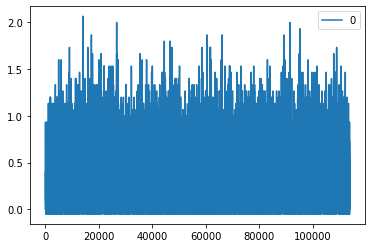

In [ ]:
if train_agent:
    tf.compat.v1.disable_eager_execution()

    # initialize board
    board = ChessEnv(opponent=None)

    # create critic
    #critic = ActorCriticAgent(network='cnn', lr=0.1)
    #critic = ActorCriticAgent(network='cnn', lr=0.01, gamma = 0.9, cnn_layers=8, dense_layers=3, name='A2C_64')
    critic.update_model()
    # create actor
    actor = ActorCriticAgent(network='cnn_pg', lr=0.3, dense_layers=4, cnn_layers=4)

    # learn
    run_learning = ActorCritic(actor=actor, critic=critic, env=board)
    _pgn = run_learning.learn(iters=iters) ### Takes the most time to run. as expected.


### Inspect the models

* I am looking for some sort of history for the model so that I can see how the loss is changing for the critic.

* I expect to have one avearge loss per epoch


In [ ]:
actor_h, critic_h = run_learning.get_actor_critic_loss()
actor_h = actor_h.explode('loss').apply(lambda x: x.astype(float).round(4))
critic_h = critic_h.explode('loss').explode('mae').apply(lambda x: x.astype(float).round(4))
print('*************************')
print('*************************')
print('CRITIC LOSS SUMMARY\n')
print('*************************')
print('*************************')
print(critic_h.describe())
print('*************************')
print('*************************')
print('ACTOR LOSS SUMMARY\n')
print('*************************')
print('*************************')
print(actor_h.describe())

*************************
*************************
CRITIC LOSS SUMMARY

*************************
*************************
              loss          mae
count  1000.000000  1000.000000
mean      0.001066     0.000681
std       0.000536     0.001745
min       0.000000     0.000000
25%       0.000700     0.000200
50%       0.000900     0.000200
75%       0.001300     0.000400
max       0.003400     0.030100
*************************
*************************
ACTOR LOSS SUMMARY

*************************
*************************
              loss
count  1000.000000
mean      0.005350
std       0.004113
min       0.000000
25%       0.003800
50%       0.004700
75%       0.005500
max       0.037200


Text(0.5, 0, 'Model Iteration')

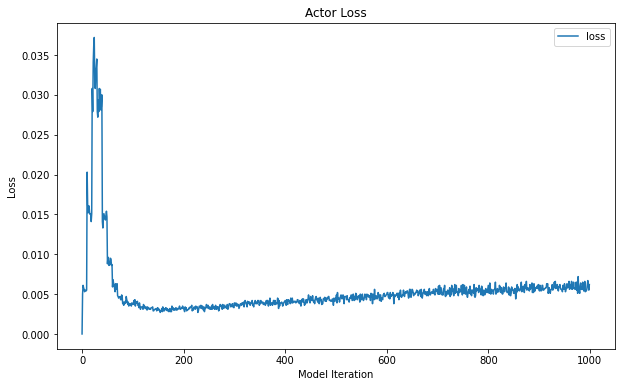

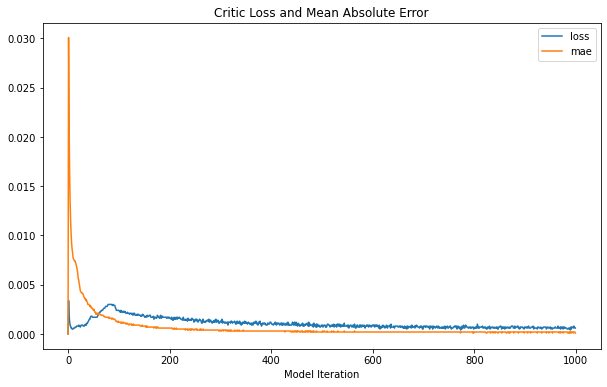

In [ ]:
ac_plt = actor_h.plot(title = 'Actor Loss',figsize=(10, 6))
ac_plt.set_xlabel("Model Iteration")
ac_plt.set_ylabel("Loss") 

ct_plt = critic_h.plot(title = 'Critic Loss and Mean Absolute Error',figsize=(10, 6))
ct_plt.set_xlabel("Model Iteration")
 

Text(0.5, 0, 'Model Iteration 100+')

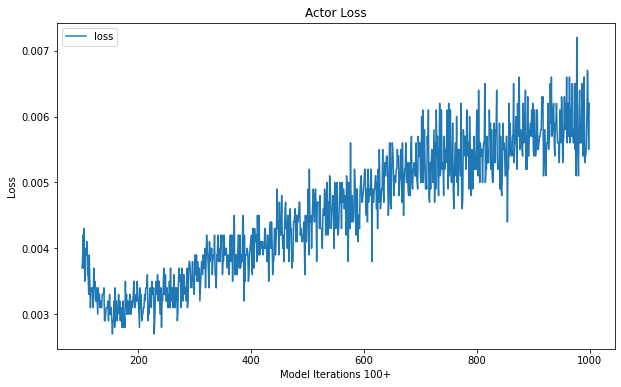

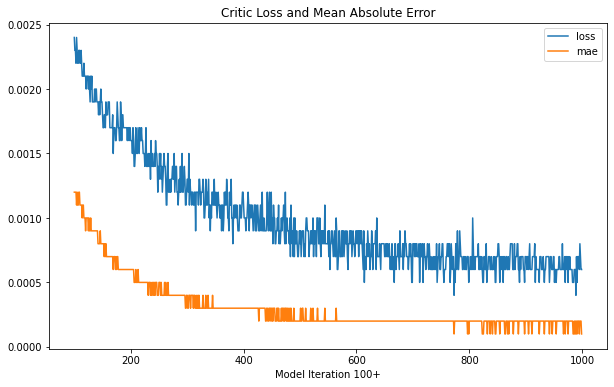

In [ ]:
ac_plt = actor_h.iloc[100:,:].plot(title = 'Actor Loss',figsize=(10, 6))
ac_plt.set_xlabel("Model Iterations 100+")
ac_plt.set_ylabel("Loss") 

ct_plt = critic_h.iloc[100:,:].plot(title = 'Critic Loss and Mean Absolute Error',figsize=(10, 6))
ct_plt.set_xlabel("Model Iteration 100+")
 

### Test Agents

In [ ]:
def play_game(player, opponent, actor=False, display=False):
  # Create environment
  env = ChessEnv(opponent=opponent)

  # Play Game
  ## Starts with player
  is_white = 1
  total_game_time = 0

  turn = 1
  while not env._is_done():
    # set up base variables
    #root = node()
    #root.state = env.board
    state = env.board
    action = None
    current_player = player if is_white else env.opponent

    # observe action to take
    #print('Turn: {}'.format(turn))
    start = time.time()
    actor_move=False
    if is_white:
      action = player.observe(state, env=env)
      if actor:
        actor_move=True
    else:
      action = env.opponent.observe(state, env=env)
    end = time.time()
    duration = end - start
    total_game_time += duration
    # perform action
    if actor_move:
        episode_end, reward = env.step_numerical(action)
    else:
        env.step(action)
    if display:
      print('{} Moved: {}, time taken to move: {:.2f}s'.format(current_player.name, action, duration))
    

    if not is_white and display:
      env.render_image_jupyter()
    is_white ^= 1
    turn+=1

  return env, total_game_time

Created Agent Actor-Critic Based Agent
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board_layer (InputLayer)       [(None, 8, 8, 8)]    0           []                               
                                                                                                  
 conv2d_17 (Conv2D)             (None, 8, 8, 32)     2336        ['board_layer[0][0]']            
                                                                                                  
 conv2d_18 (Conv2D)             (None, 8, 8, 32)     9248        ['conv2d_17[0][0]']              
                                                                                                  
 conv2d_19 (Conv2D)             (None, 8, 8, 32)     9248        ['conv2d_18[0][0]']              
                                                     

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Total Game Time: 13.136319398880005s

Final Board:


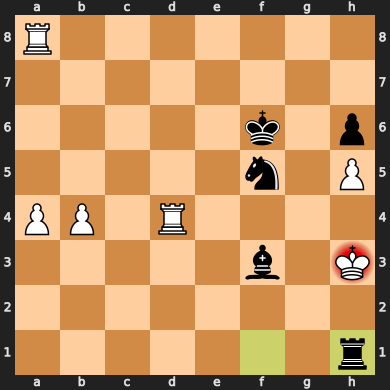


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 2 ==============================
Total Game Time: 15.302823781967163s

Final Board:


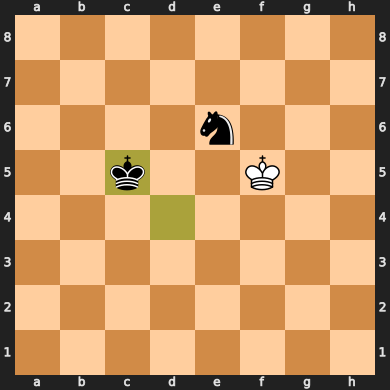


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 3 ==============================
Total Game Time: 10.962994575500488s

Final Board:


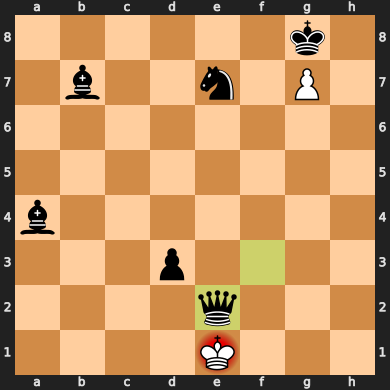


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 4 ==============================
Total Game Time: 8.173616886138916s

Final Board:


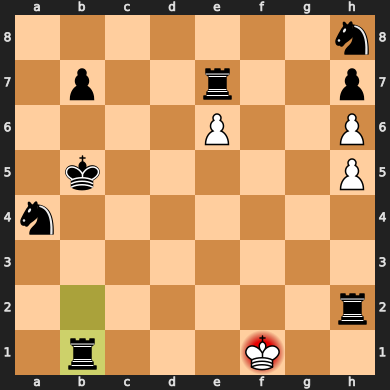


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 5 ==============================
Total Game Time: 21.911375522613525s

Final Board:


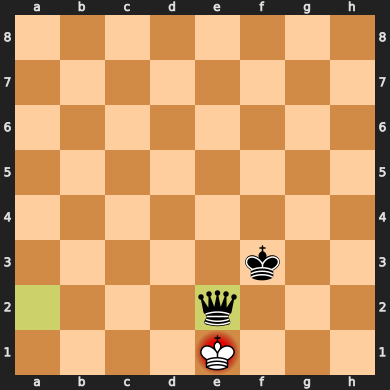


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 6 ==============================
Total Game Time: 4.821573495864868s

Final Board:


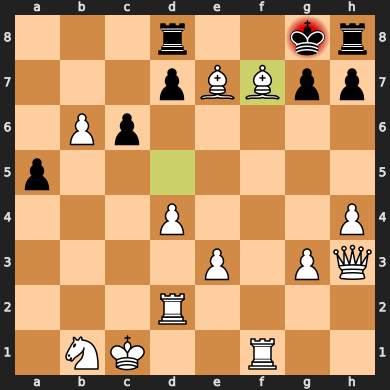


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 7 ==============================
Total Game Time: 3.3596479892730713s

Final Board:


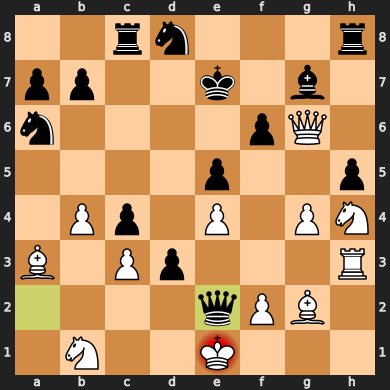


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 8 ==============================
Total Game Time: 16.5905179977417s

Final Board:


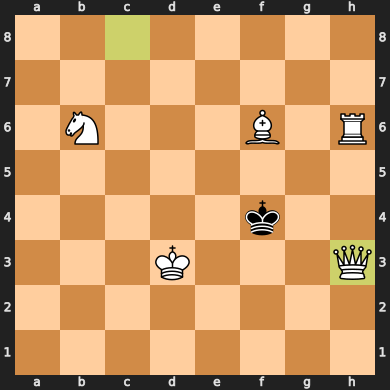


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 9 ==============================
Total Game Time: 8.706191301345825s

Final Board:


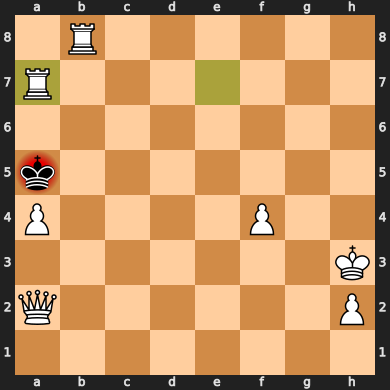


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 10 ==============================
Total Game Time: 15.720362901687622s

Final Board:


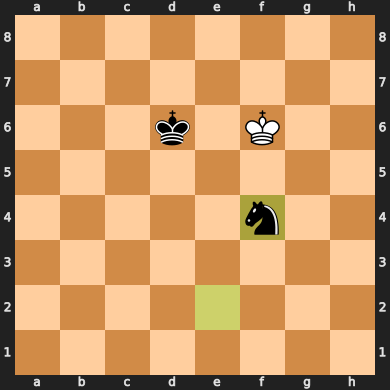


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 11 ==============================
Total Game Time: 9.72436809539795s

Final Board:


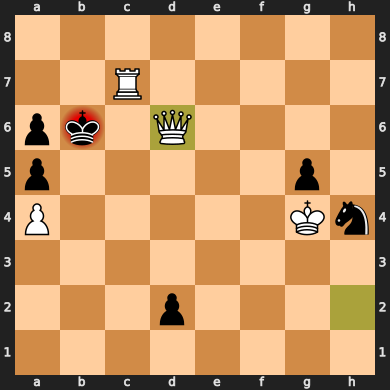


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 12 ==============================
Total Game Time: 23.399487495422363s

Final Board:


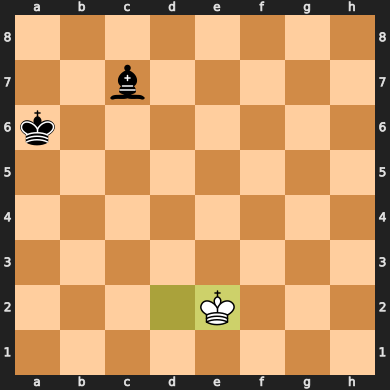


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 13 ==============================
Total Game Time: 11.627532005310059s

Final Board:


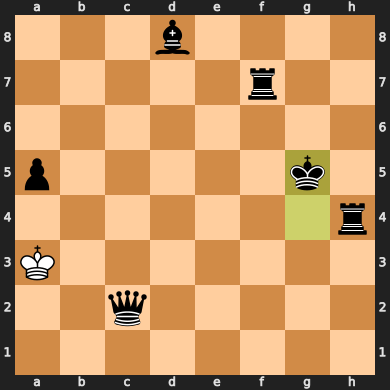


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 14 ==============================
Total Game Time: 12.477499961853027s

Final Board:


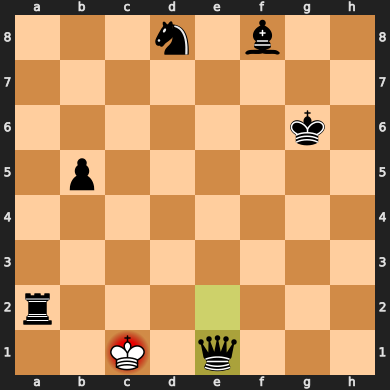


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 15 ==============================
Total Game Time: 10.103631258010864s

Final Board:


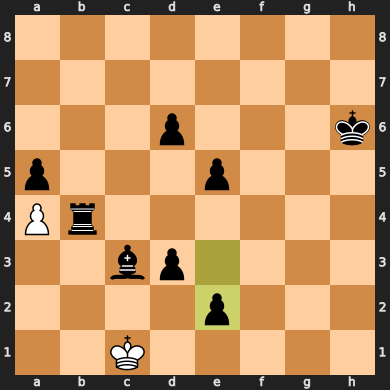


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 16 ==============================
Total Game Time: 14.297390699386597s

Final Board:


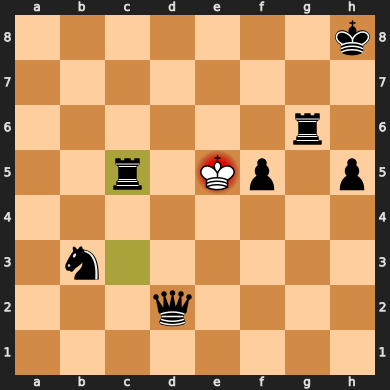


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 17 ==============================
Total Game Time: 0.42028164863586426s

Final Board:


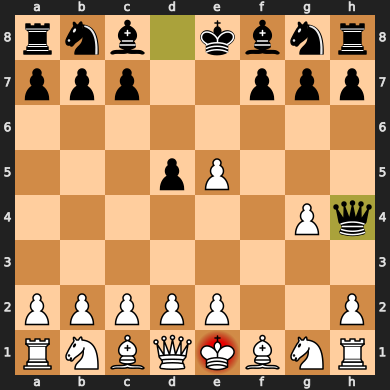


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 18 ==============================
Total Game Time: 14.062392473220825s

Final Board:


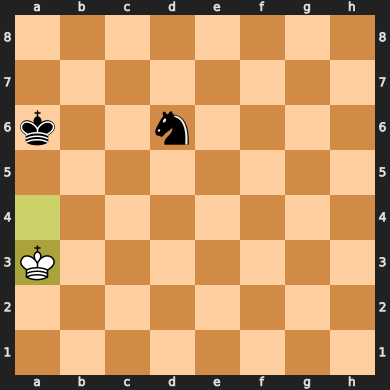


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 19 ==============================
Total Game Time: 24.360244750976562s

Final Board:


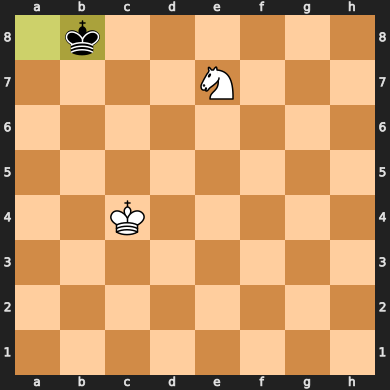


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 20 ==============================
Total Game Time: 16.36457896232605s

Final Board:


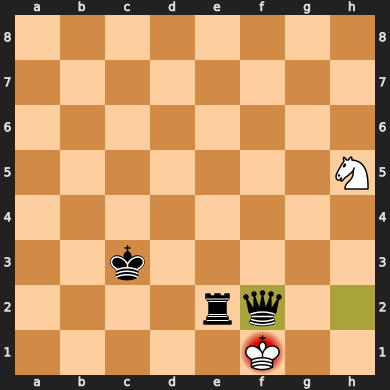


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 21 ==============================
Total Game Time: 22.23908495903015s

Final Board:


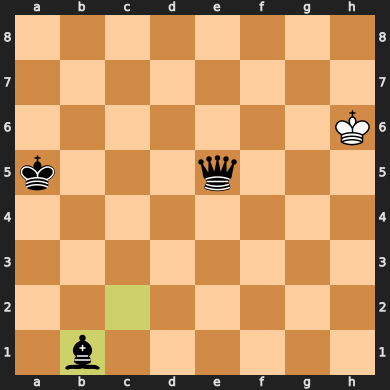


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 22 ==============================
Total Game Time: 14.619515419006348s

Final Board:


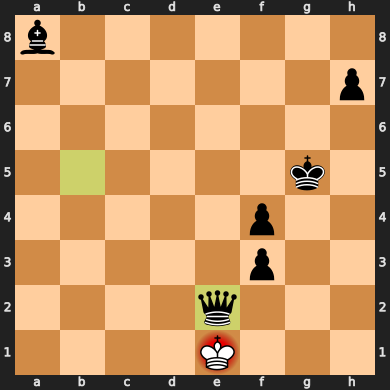


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 23 ==============================
Total Game Time: 13.463870525360107s

Final Board:


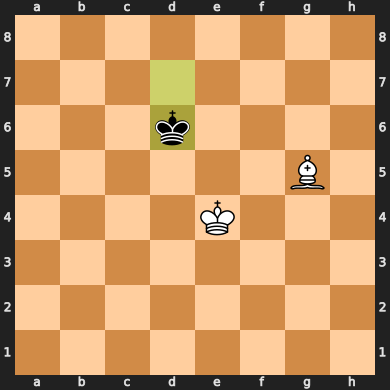


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 24 ==============================
Total Game Time: 12.76493787765503s

Final Board:


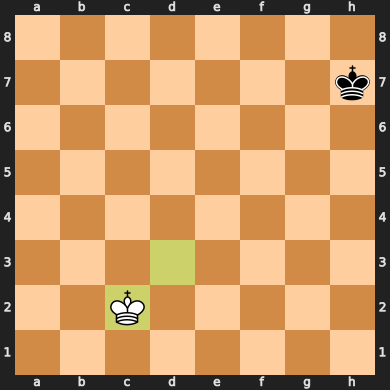


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 25 ==============================
Total Game Time: 24.625232934951782s

Final Board:


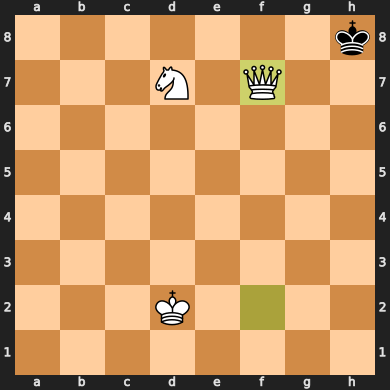


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 26 ==============================
Total Game Time: 8.839958190917969s

Final Board:


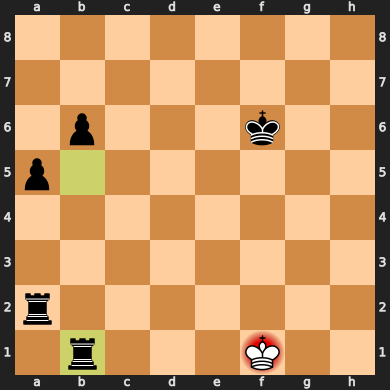


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 27 ==============================
Total Game Time: 7.973846912384033s

Final Board:


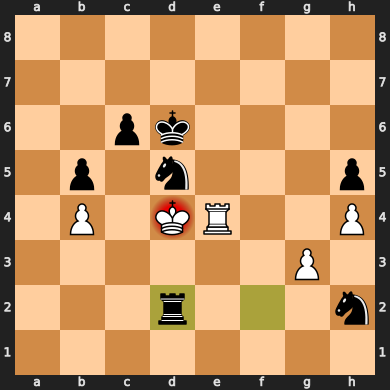


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 28 ==============================
Total Game Time: 3.355785608291626s

Final Board:


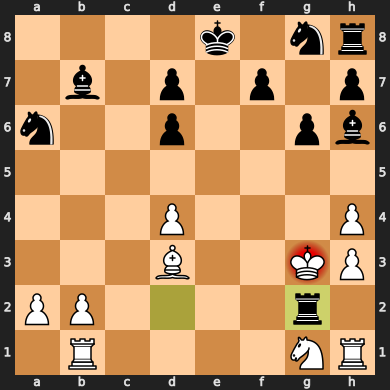


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 29 ==============================
Total Game Time: 14.166471719741821s

Final Board:


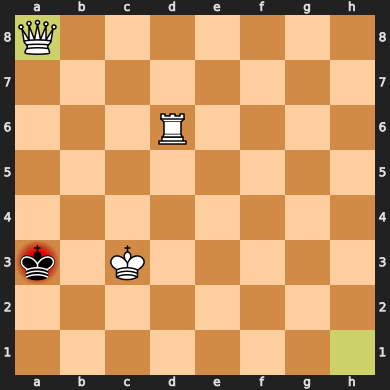


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 30 ==============================
Total Game Time: 5.872849225997925s

Final Board:


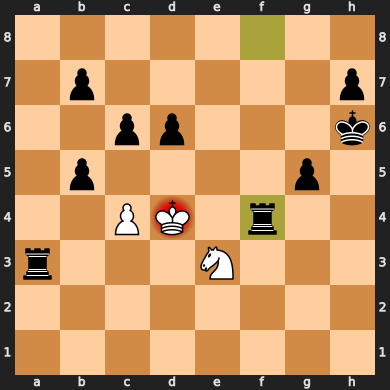


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 31 ==============================
Total Game Time: 14.603875637054443s

Final Board:


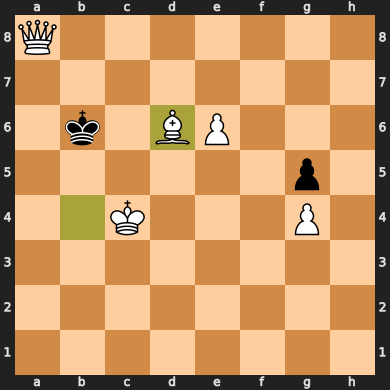


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 32 ==============================
Total Game Time: 4.824785232543945s

Final Board:


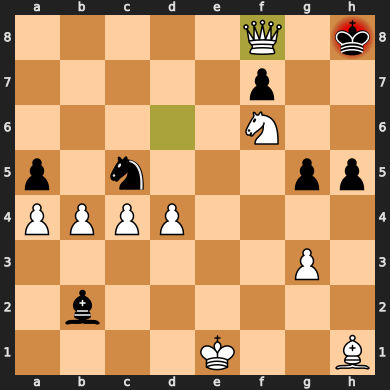


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 33 ==============================
Total Game Time: 6.596238851547241s

Final Board:


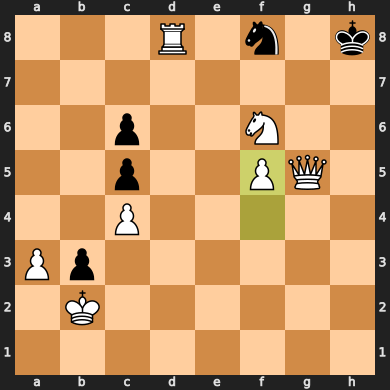


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 34 ==============================
Total Game Time: 19.271485328674316s

Final Board:


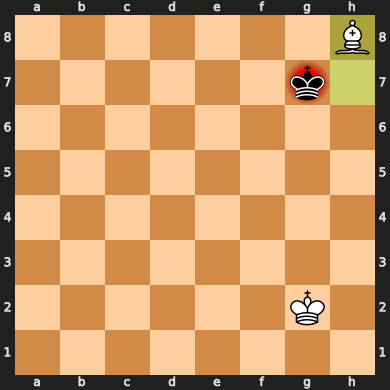


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 35 ==============================
Total Game Time: 15.718581676483154s

Final Board:


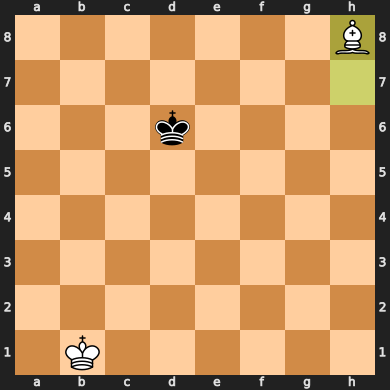


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 36 ==============================
Total Game Time: 10.049960613250732s

Final Board:


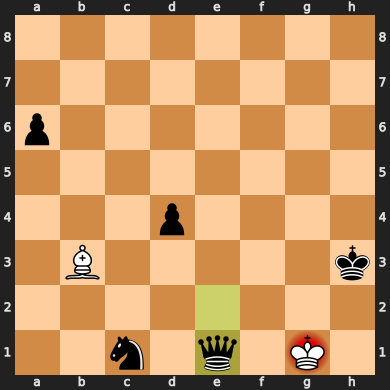


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 37 ==============================
Total Game Time: 18.2485032081604s

Final Board:


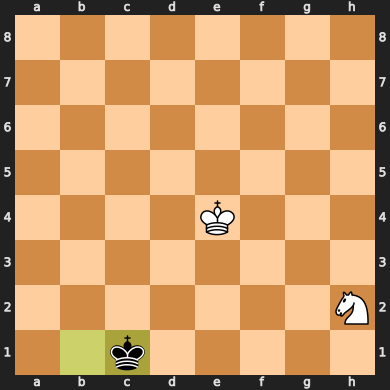


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 38 ==============================
Total Game Time: 7.3537046909332275s

Final Board:


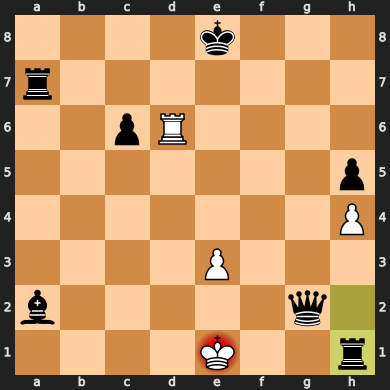


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 39 ==============================
Total Game Time: 11.304606914520264s

Final Board:


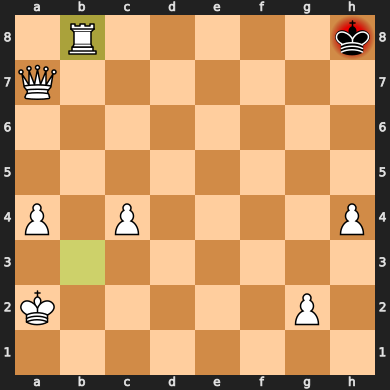


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 40 ==============================
Total Game Time: 4.189932823181152s

Final Board:


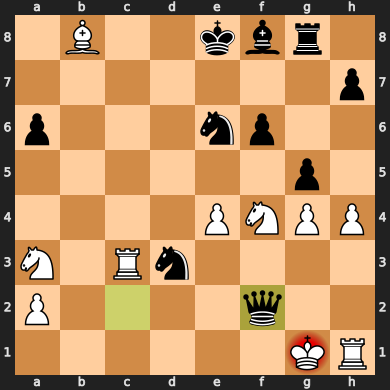


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 41 ==============================
Total Game Time: 16.550355672836304s

Final Board:


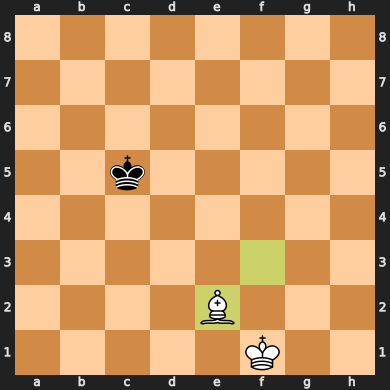


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 42 ==============================
Total Game Time: 16.77406930923462s

Final Board:


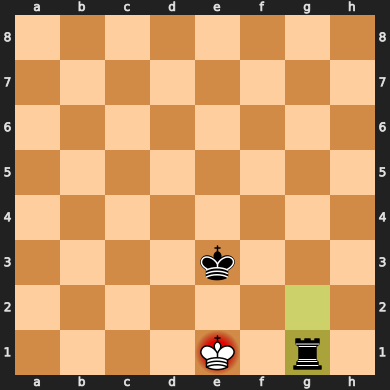


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 43 ==============================
Total Game Time: 21.62507939338684s

Final Board:


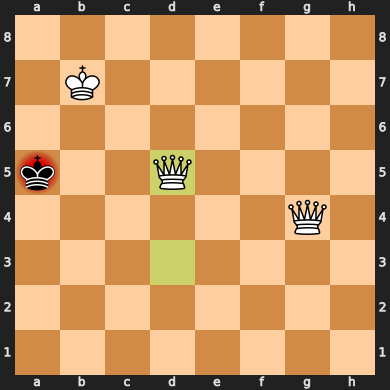


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 44 ==============================
Total Game Time: 19.929453372955322s

Final Board:


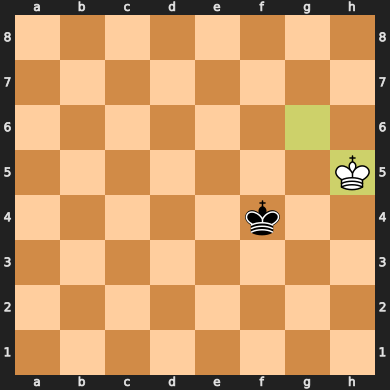


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 45 ==============================
Total Game Time: 20.8914897441864s

Final Board:


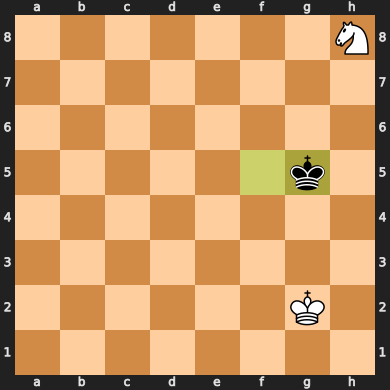


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 46 ==============================
Total Game Time: 21.47756266593933s

Final Board:


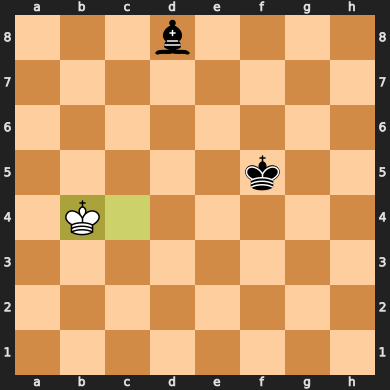


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 47 ==============================
Total Game Time: 15.751701831817627s

Final Board:


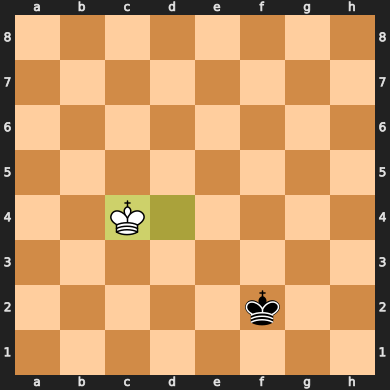


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 48 ==============================
Total Game Time: 14.044960737228394s

Final Board:


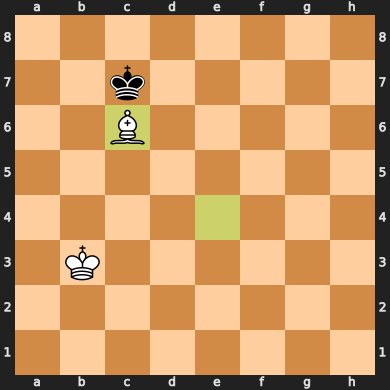


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 49 ==============================
Total Game Time: 18.446155071258545s

Final Board:


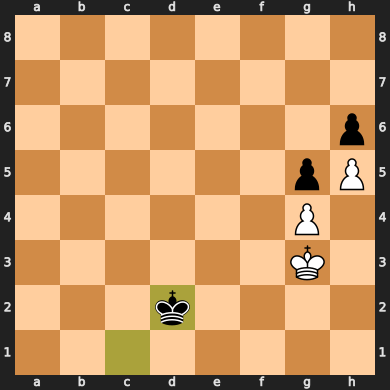


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 50 ==============================
Total Game Time: 14.022717952728271s

Final Board:


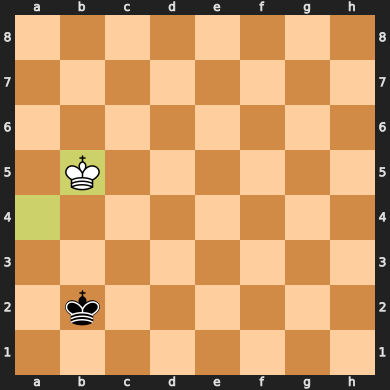


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 51 ==============================
Total Game Time: 24.095913648605347s

Final Board:


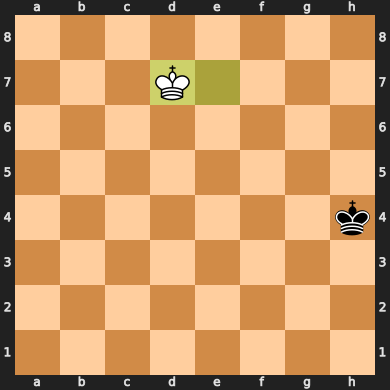


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 52 ==============================
Total Game Time: 12.033345937728882s

Final Board:


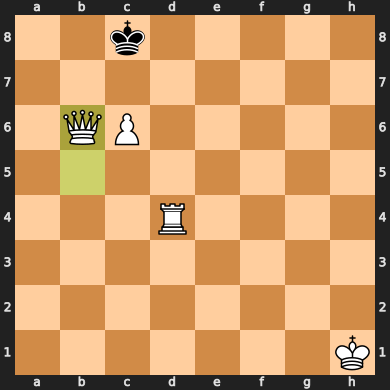


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 53 ==============================
Total Game Time: 11.953145742416382s

Final Board:


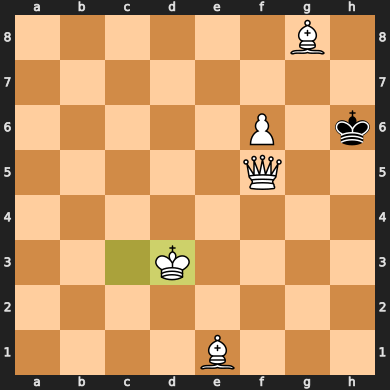


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 54 ==============================
Total Game Time: 28.411162614822388s

Final Board:


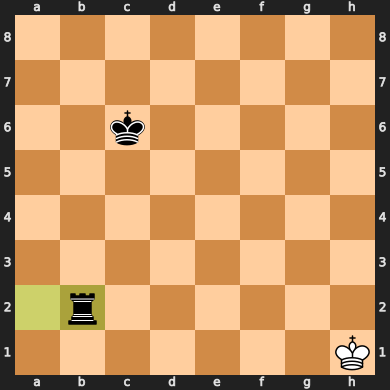


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 55 ==============================
Total Game Time: 11.045865535736084s

Final Board:


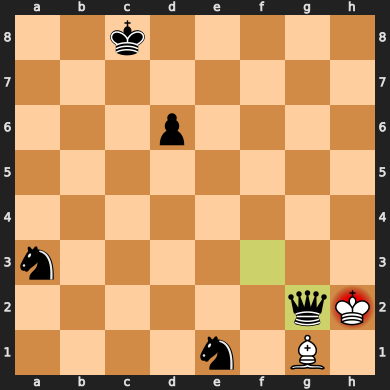


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 56 ==============================
Total Game Time: 13.624162435531616s

Final Board:


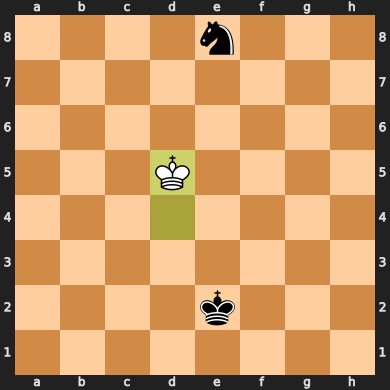


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 57 ==============================
Total Game Time: 16.99274230003357s

Final Board:


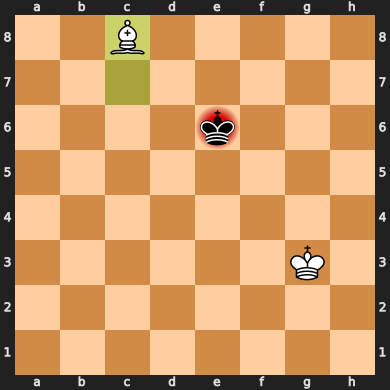


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 58 ==============================
Total Game Time: 14.02884292602539s

Final Board:


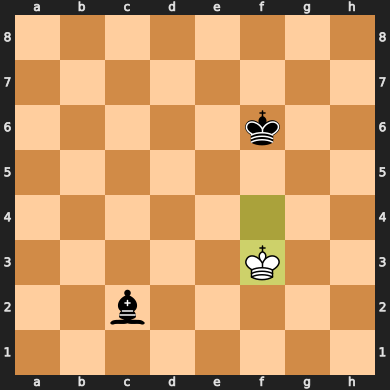


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 59 ==============================
Total Game Time: 16.244325399398804s

Final Board:


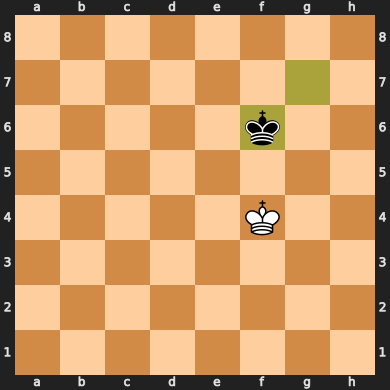


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 60 ==============================
Total Game Time: 14.879012823104858s

Final Board:


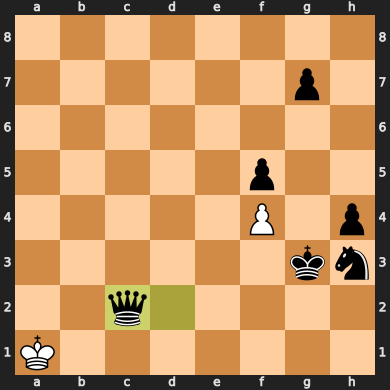


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 61 ==============================
Total Game Time: 22.84125852584839s

Final Board:


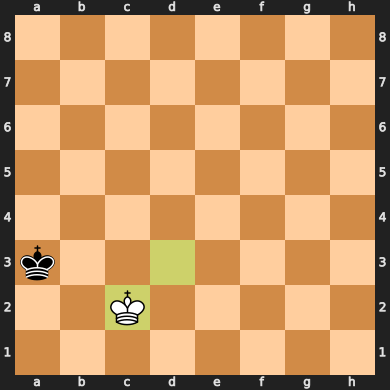


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 62 ==============================
Total Game Time: 1.6886038780212402s

Final Board:


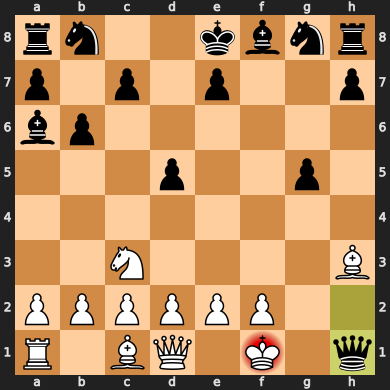


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 63 ==============================
Total Game Time: 16.974151372909546s

Final Board:


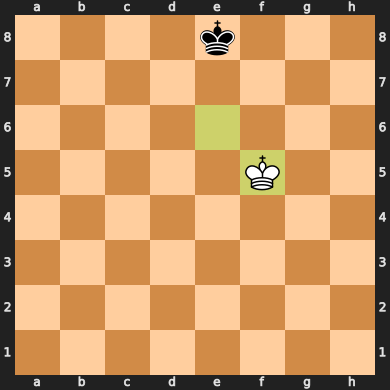


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 64 ==============================
Total Game Time: 11.088802814483643s

Final Board:


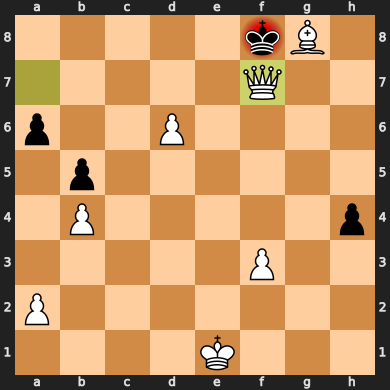


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 65 ==============================
Total Game Time: 3.3446717262268066s

Final Board:


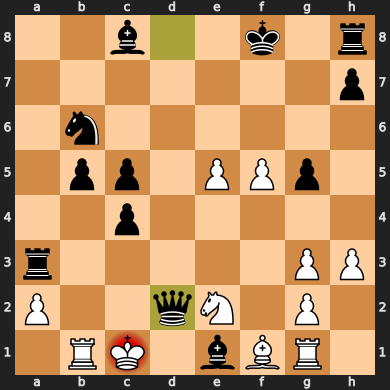


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 66 ==============================
Total Game Time: 16.12474536895752s

Final Board:


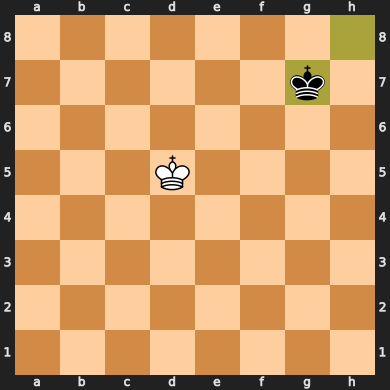


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 67 ==============================
Total Game Time: 9.721883058547974s

Final Board:


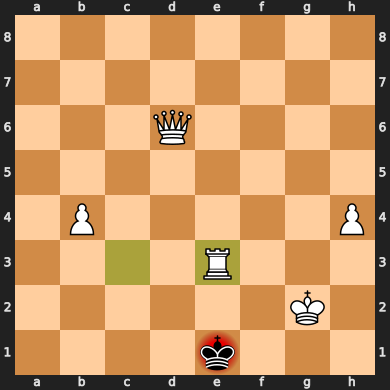


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 68 ==============================
Total Game Time: 22.58554434776306s

Final Board:


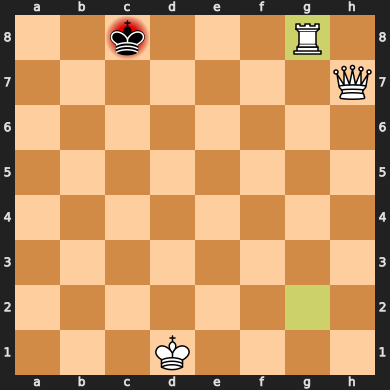


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 69 ==============================
Total Game Time: 12.070516347885132s

Final Board:


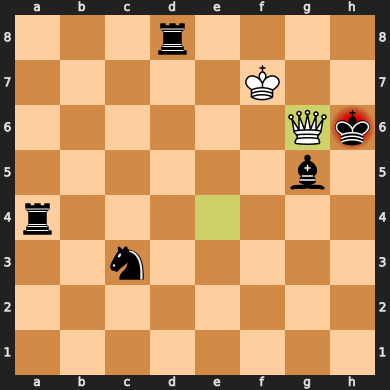


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 70 ==============================
Total Game Time: 16.324392080307007s

Final Board:


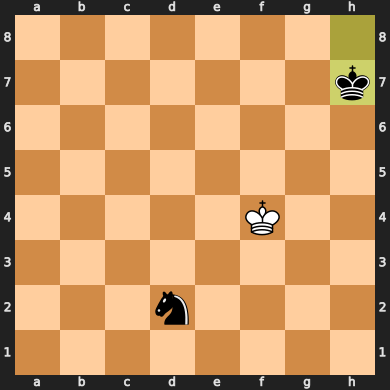


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 71 ==============================
Total Game Time: 20.711288690567017s

Final Board:


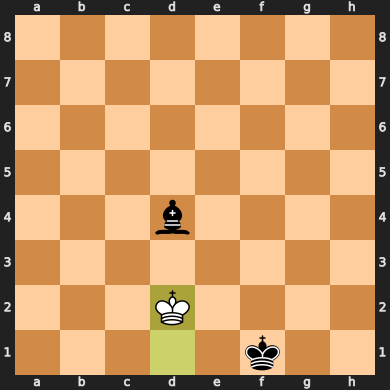


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 72 ==============================
Total Game Time: 20.813002109527588s

Final Board:


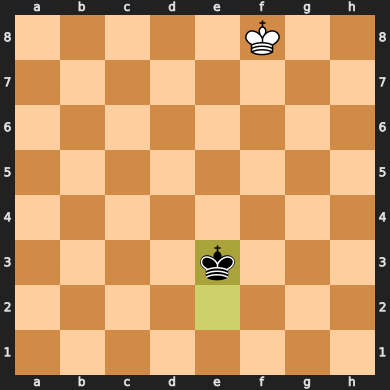


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 73 ==============================
Total Game Time: 5.231949090957642s

Final Board:


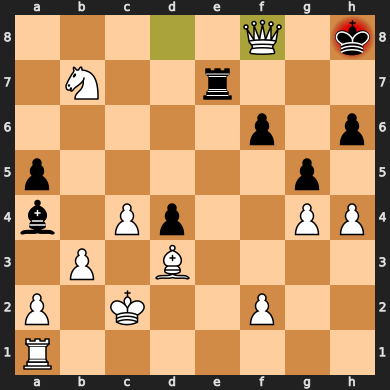


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 74 ==============================
Total Game Time: 2.9315543174743652s

Final Board:


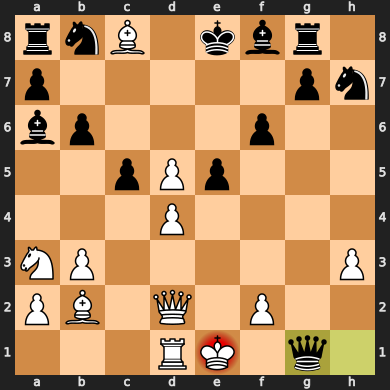


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 75 ==============================
Total Game Time: 13.16463851928711s

Final Board:


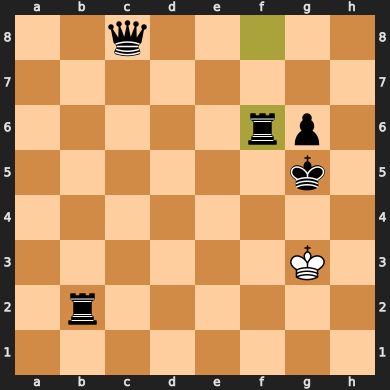


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 76 ==============================
Total Game Time: 3.1380908489227295s

Final Board:


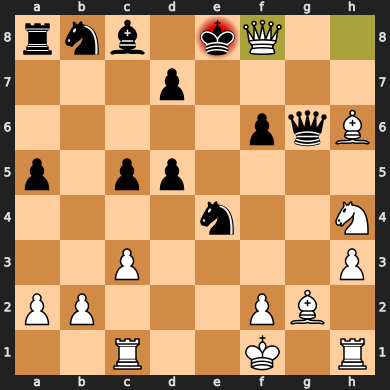


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 77 ==============================
Total Game Time: 15.74131464958191s

Final Board:


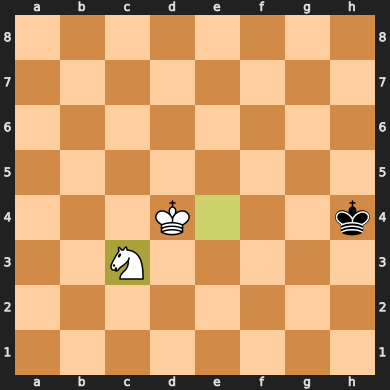


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 78 ==============================
Total Game Time: 16.897640466690063s

Final Board:


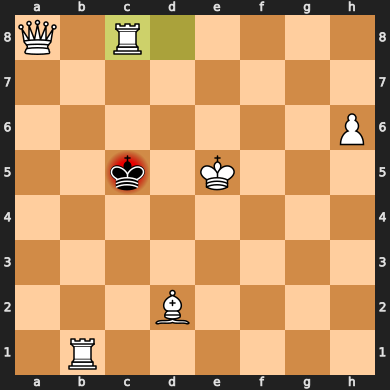


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 79 ==============================
Total Game Time: 21.761885404586792s

Final Board:


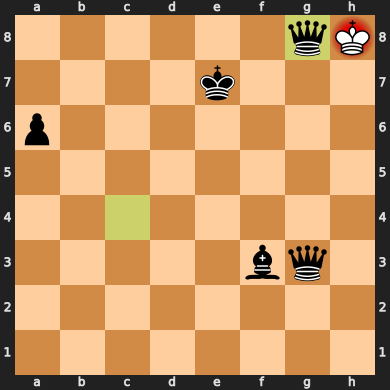


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 80 ==============================
Total Game Time: 16.13481855392456s

Final Board:


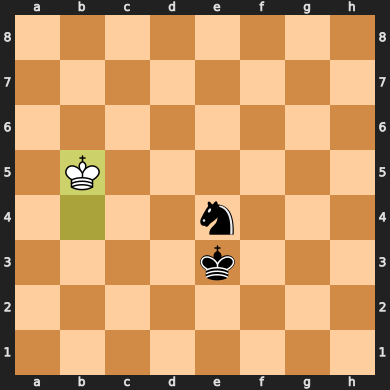


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 81 ==============================
Total Game Time: 16.94040012359619s

Final Board:


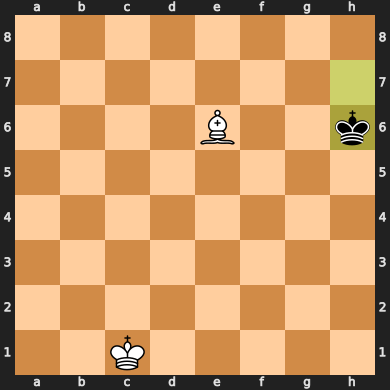


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 82 ==============================
Total Game Time: 3.5678205490112305s

Final Board:


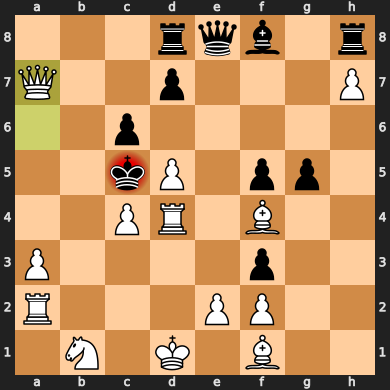


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 83 ==============================
Total Game Time: 13.842382907867432s

Final Board:


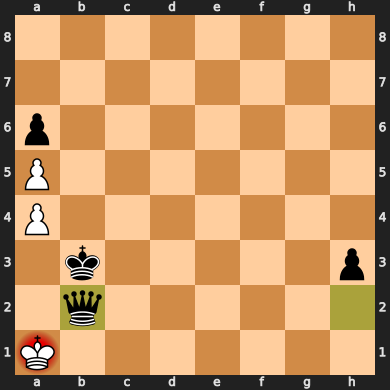


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 84 ==============================
Total Game Time: 9.661313533782959s

Final Board:


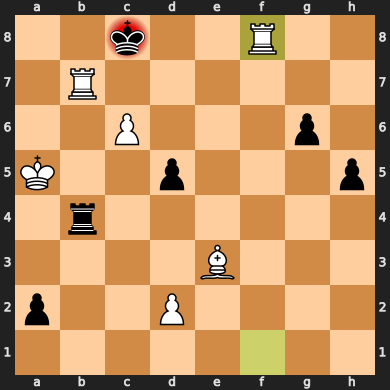


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 85 ==============================
Total Game Time: 25.719141006469727s

Final Board:


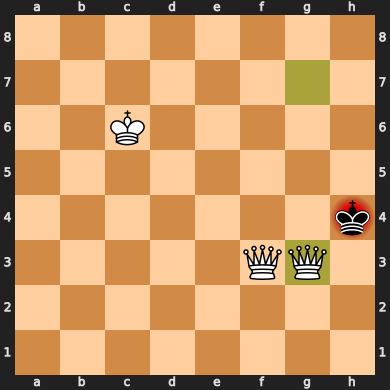


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 86 ==============================
Total Game Time: 5.651333570480347s

Final Board:


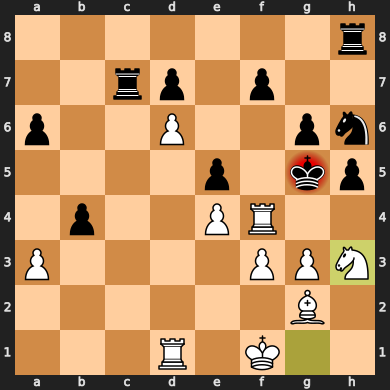


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 87 ==============================
Total Game Time: 10.252890348434448s

Final Board:


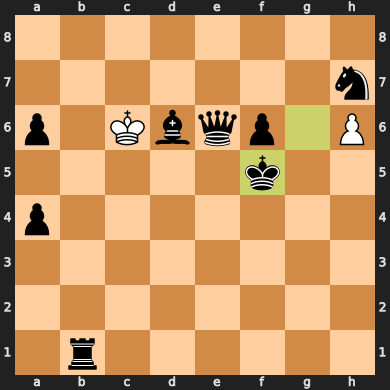


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 88 ==============================
Total Game Time: 4.131955862045288s

Final Board:


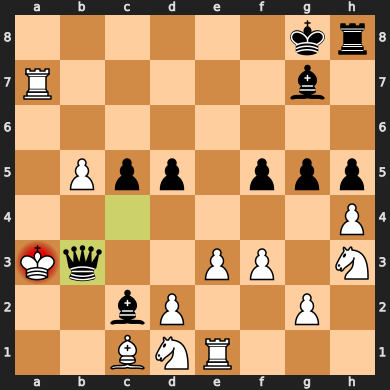


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 89 ==============================
Total Game Time: 15.101688146591187s

Final Board:


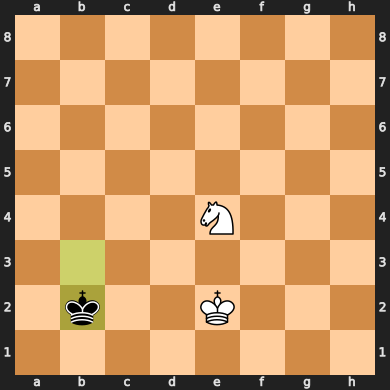


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 90 ==============================
Total Game Time: 22.008336305618286s

Final Board:


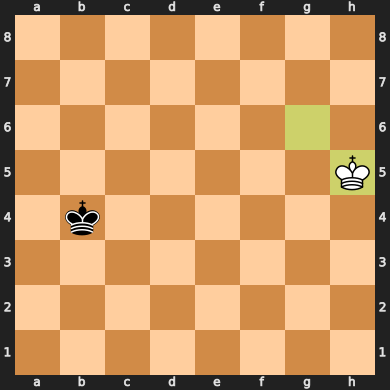


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 91 ==============================
Total Game Time: 4.181720733642578s

Final Board:


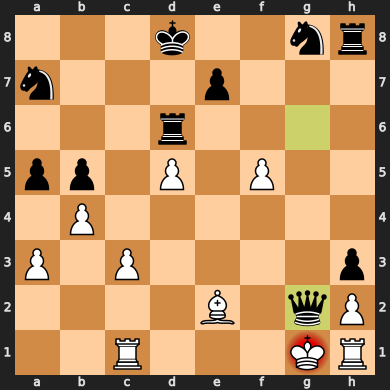


(Black) Stockfish Agent - Won the Game
============================== Starting Episode: 92 ==============================
Total Game Time: 13.188927173614502s

Final Board:


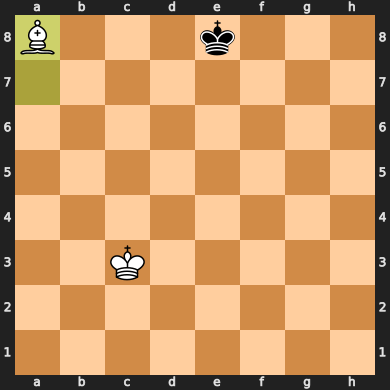


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 93 ==============================
Total Game Time: 28.103264331817627s

Final Board:


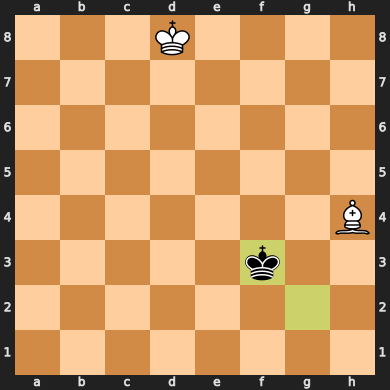


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 94 ==============================
Total Game Time: 19.03383469581604s

Final Board:


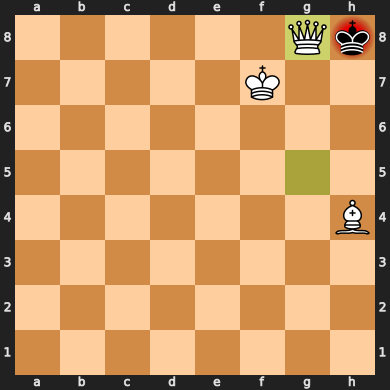


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 95 ==============================
Total Game Time: 11.315048933029175s

Final Board:


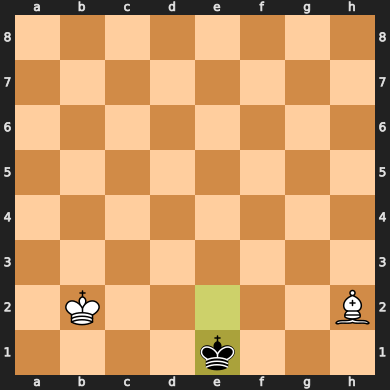


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 96 ==============================
Total Game Time: 27.270090579986572s

Final Board:


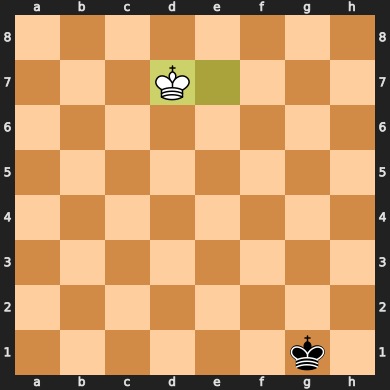


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 97 ==============================
Total Game Time: 17.16618585586548s

Final Board:


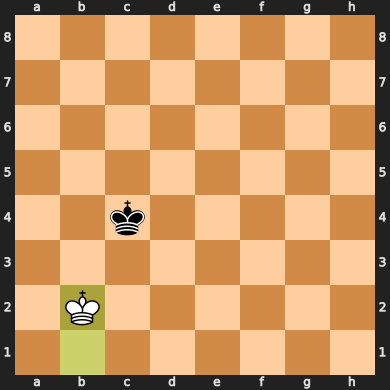


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 98 ==============================
Total Game Time: 6.083409309387207s

Final Board:


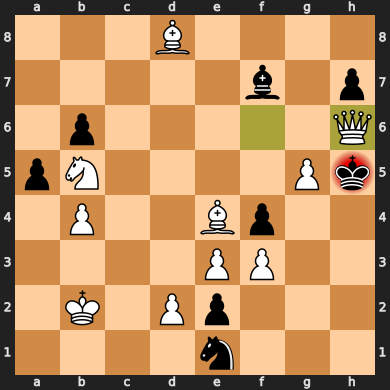


(White) Actor-Critic Based Agent - Won the Game
============================== Starting Episode: 99 ==============================
Total Game Time: 22.630384922027588s

Final Board:


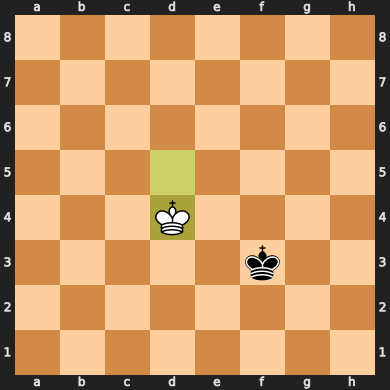


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent
============================== Starting Episode: 100 ==============================
Total Game Time: 21.132344484329224s

Final Board:


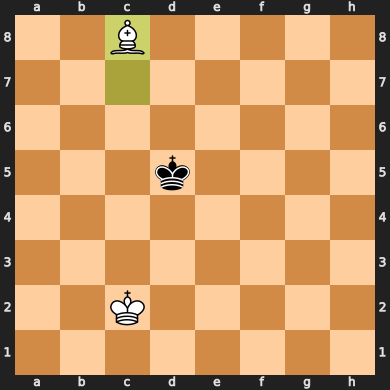


Game was a Draw between Actor-Critic Based Agent vs. Stockfish Agent


============================== SUMMARY ==============================
Actor-Critic Based Agent -- Wins: 20
Stockfish Agent -- Wins: 26
Draws: 54


In [ ]:
# Create opponent
#opponent = MCTSAgent(name='MCTS Based Agent', is_white=False, multithreading=False)
#player = MCTSAgent(name='Player', is_white=True, multithreading=False)
#actor=False
player = ActorCriticAgent(network='cnn_pg', lr=0.3, cnn_layers=4, dense_layers=4, name='Actor-Critic Based Agent')
#player = ActorCriticAgent(network='cnn_pg', lr=0.3, dense_layers=4, cnn_layers=3, name='Actor-Critic Based Agent')
player.model.summary()
player.load_model(name=save_path+'/actor_final.h5')
actor=True
opponent = StockfishAgent(name='Stockfish Agent', is_white=False, skill_lvl=1)

games = 100
episode = 0

white_wins = 0
black_wins = 0
draws = 0

while episode < games:
  print('='*30 + ' Starting Episode: {} '.format(episode+1) + '='*30)
  env, total_game_time = play_game(player, opponent, actor=actor)

  print('Total Game Time: {}s'.format(total_game_time))
  print('')
  print('Final Board:')
  env.render_image_jupyter()
  print('')

  reward = env._reward()

  if reward == 1:
    print('(White) {} - Won the Game'.format(player.name))
    white_wins+=1
  elif reward == -1:
    print('(Black) {} - Won the Game'.format(env.opponent.name))
    black_wins+=1
  else:
    print('Game was a Draw between {} vs. {}'.format(player.name, env.opponent.name))
    draws+=1

  episode += 1

print('')
print('')
print('='*30 + ' SUMMARY '.format(episode+1) + '='*30)
print('{} -- Wins: {}'.format(player.name, white_wins))
print('{} -- Wins: {}'.format(opponent.name, black_wins))
print('Draws: {}'.format(draws))

looks like our agent gets close to a piece to win the game. may need a higher filter on the cnn.


*   Game [A2C] 71 vs 56 [SF]
*   Using a larger [5*5] filter leads to poorer performance (Stockfish crushes the A2C
*   Agent is learning to draw matches since there is an imbalance in the replay buffer
*   Agent doesnt truly know how to handle the endgame

============================== SUMMARY ==============================

Actor-Critic Based Agent -- Wins: **19**

Stockfish Agent -- Wins: 25

Draws: 56


__________

using mdl 1000 produced

============================== SUMMARY ==============================

Actor-Critic Based Agent -- Wins: **28**

Stockfish Agent -- Wins: 28

Draws: 44



============================== SUMMARY ==============================

Actor-Critic Based Agent -- Wins: 20

Stockfish Agent -- Wins: 26

Draws: 54
